# Imports

In [1]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.typing import Tensor
from torch_geometric.transforms import RandomLinkSplit
import pandas as pd
import torch
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.data import HeteroData
import tqdm
import os
import warnings

warnings.filterwarnings("ignore")

# Model Architecture

In [2]:
class GNNModel(nn.Module):

    def __init__(self, user_dim: int, movie_dim: int, hidden_dim: int):
        super().__init__()

        self.conv1 = HeteroConv({
            ("user", "rates", "movie"): SAGEConv((user_dim, movie_dim), hidden_dim),
            ("movie", "rated_by", "user"): SAGEConv((movie_dim, user_dim), hidden_dim),
        }, aggr="sum")

        self.conv2 = HeteroConv({
            ("user", "rates", "movie"): SAGEConv(hidden_dim, hidden_dim),
            ("movie", "rated_by", "user"): SAGEConv(hidden_dim, hidden_dim),
        }, aggr="sum")

    def forward(self, x: Tensor, edge_index: Tensor):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [3]:
class RecSystem(nn.Module):

    def __init__(self, user_dim, movie_dim, hidden_dim):
        super().__init__()

        self.gnn = GNNModel(user_dim, movie_dim, hidden_dim)
        self.cos_sim = nn.CosineSimilarity()
        self.scale_to_rating = lambda x: (x + 1) * 2.5

    def forward(self, data: HeteroData, get_embeddings=False) -> Tensor:
        x, edge_index = data.x_dict, data.edge_index_dict

        node_embeddings = self.gnn(x, edge_index)

        if get_embeddings:
            return node_embeddings

        edge_label_index = data["user", "rates", "movie"].edge_label_index

        edge_feat_user = node_embeddings["user"][edge_label_index[0]]
        edge_feat_movie = node_embeddings["movie"][edge_label_index[1]]

        return self.scale_to_rating(self.cos_sim(edge_feat_user, edge_feat_movie))

    def predict_ratings(self, user_embeds: Tensor, movie_embeds: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_user = user_embeds[edge_label_index[0]]
        edge_feat_movie = movie_embeds[edge_label_index[1]]

        return self.scale_to_rating(self.cos_sim(edge_feat_user, edge_feat_movie))

# Data preparation

In [5]:
def create_bipartite_graph_from_dataset(set_id):
    user_df = pd.read_csv("../data/interim/users.csv", index_col='user_id')
    user_mapping = {idx: i for i, idx in enumerate(user_df.index)}

    movie_df = pd.read_csv("../data/interim/items.csv", index_col='movie_id')
    movie_mapping = {idx: i for i, idx in enumerate(movie_df.index)}

    genres = pd.read_csv("../data/raw/ml-100k/u.genre", delimiter="|", names=["name", "genre_id"])
    occupation = pd.read_csv("../data/raw/ml-100k/u.occupation", names=["occupation"])
    occupation['occupation'] = 'occupation_' + occupation['occupation'].astype(str)

    result = []
    for rating_path in [f"../data/raw/ml-100k/u{set_id}.base", f"../data/raw/ml-100k/u{set_id}.test"]:
        data = HeteroData()
        data['movie'].x = torch.from_numpy(movie_df[genres.name].values.astype(float)).to(torch.float)
        data['user'].x = torch.cat(
            [torch.from_numpy(user_df['age'].values / user_df['age'].values.max()).to(torch.float).view(-1, 1),
             torch.from_numpy(user_df[['F', 'M']].values).to(torch.float),
             torch.from_numpy(user_df[occupation['occupation']].values).to(torch.float)], dim=-1)

        df = pd.read_csv(rating_path, sep='\t', header=None, names=["user_id", "movie_id", "rating", "timestamp"])

        src = [user_mapping[idx] for idx in df['user_id']]
        dst = [movie_mapping[idx] for idx in df['movie_id']]

        data['user', 'rates', 'movie'].edge_index = torch.tensor([src, dst])
        data['user', 'rates', 'movie'].edge_label = torch.from_numpy(df['rating'].values).to(torch.long)
        data['movie', 'rated_by', 'user'].edge_index = torch.tensor([src, dst]).flip([0])

        result.append(data)

    return result

In [6]:
data_parts = ["1", "2", "3", "4", "5", "a", "b"]

transform = RandomLinkSplit(num_val=0.2, num_test=0.0, add_negative_train_samples=False, neg_sampling_ratio=0.0,
                            edge_types=("user", "rates", "movie"), rev_edge_types=("movie", "rated_by", "user"), )

for part in data_parts:
    data, test_data = create_bipartite_graph_from_dataset(part)
    train_data, val_data, _ = transform(data)

    torch.save(train_data.to_dict(), f"../data/prepared/data{part}_train.pt")
    torch.save(test_data.to_dict(), f"../data/prepared/data{part}_test.pt")
    torch.save(val_data.to_dict(), f"../data/prepared/data{part}_val.pt")

# Training

In [8]:
BEST_MODEL_PATH = "../models/best_model_{}.pt"
LOGS_DIR_PATH = "../benchmark/logs"
BENCHMARK_DIR_PATH = "../benchmark"

In [5]:
def train_loop(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    train_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for i, sampled_data in enumerate(train_bar):
        optimizer.zero_grad()
        # Get predictions from model and true labels
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        # Calculate loss and update gradients
        loss = loss_fn(pred, ground_truth.float())
        loss.backward()
        optimizer.step()
        # Keep track of total loss
        total_loss += loss.item()

        train_bar.set_postfix({"train_loss_rmse": (total_loss / (i + 1)) ** 0.5})

    # Get average loss per epoch
    total_loss = total_loss / len(train_loader)
    return total_loss ** 0.5

In [6]:
def validate(model, val_data, loss_fn):
    model.eval()
    with torch.no_grad():
        # Get predictions from model and true labels
        embeds = model(val_data, get_embeddings=True)
        edges = val_data["user", "rates", "movie"].edge_label_index
        pred = model.predict_ratings(embeds["user"], embeds["movie"], edges)
        ground_truth = val_data["user", "rates", "movie"].edge_label
        # Calculate loss and total loss
        loss = loss_fn(pred, ground_truth.float())
        val_loss = loss.item()
    return val_loss ** 0.5

In [6]:
epochs = 10
batch_size = 256
device = torch.device('cpu')
loss_fn = nn.MSELoss()

In [19]:
for part in data_parts:
    print("Training on part", part)

    # Loading data for training
    train_data = HeteroData(_mapping=torch.load(f"../data/prepared/data{part}_train.pt"))
    val_data = HeteroData(_mapping=torch.load(f"../data/prepared/data{part}_val.pt"))
    train_loader = LinkNeighborLoader(
        train_data,
        num_neighbors=[128] * 2,
        batch_size=batch_size,
        edge_label_index=(("user", "rates", "movie"), train_data["user", "rates", "movie"].edge_label_index),
        edge_label=train_data["user", "rates", "movie"].edge_label
    )

    model = RecSystem(user_dim=24, movie_dim=19, hidden_dim=128).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = 1e9
    validation_losses, train_losses = [], []
    for epoch in range(epochs):
        # Train loop
        train_loss = train_loop(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)

        # Validation loop
        val_loss = validate(model, val_data, loss_fn)
        validation_losses.append(val_loss)

        # Saving best model
        if val_loss < best_loss:  # Saving best model
            best_loss = val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH.format(part))

        print(f"Epoch: {epoch + 1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    with open(os.path.join(LOGS_DIR_PATH, f"train_{part}.txt"), "w") as train_data_file:
        train_data_file.write(f"{train_losses}\n{validation_losses}")

Training on part 1


Epoch 1: 100%|██████████| 250/250 [00:13<00:00, 18.78it/s, train_loss_rmse=1.07]


Epoch: 1, train_loss: 1.0682, val_loss: 1.0427


Epoch 2: 100%|██████████| 250/250 [00:13<00:00, 18.90it/s, train_loss_rmse=1.03]


Epoch: 2, train_loss: 1.0286, val_loss: 1.0241


Epoch 3: 100%|██████████| 250/250 [00:14<00:00, 17.53it/s, train_loss_rmse=1.01]


Epoch: 3, train_loss: 1.0148, val_loss: 1.0140


Epoch 4: 100%|██████████| 250/250 [00:13<00:00, 18.86it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0062, val_loss: 1.0085


Epoch 5: 100%|██████████| 250/250 [00:13<00:00, 18.74it/s, train_loss_rmse=1]   


Epoch: 5, train_loss: 1.0010, val_loss: 1.0052


Epoch 6: 100%|██████████| 250/250 [00:13<00:00, 18.69it/s, train_loss_rmse=0.997]


Epoch: 6, train_loss: 0.9973, val_loss: 1.0022


Epoch 7: 100%|██████████| 250/250 [00:13<00:00, 19.06it/s, train_loss_rmse=0.994]


Epoch: 7, train_loss: 0.9937, val_loss: 0.9997


Epoch 8: 100%|██████████| 250/250 [00:13<00:00, 18.60it/s, train_loss_rmse=0.991]


Epoch: 8, train_loss: 0.9907, val_loss: 0.9994


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.66it/s, train_loss_rmse=0.99] 


Epoch: 9, train_loss: 0.9898, val_loss: 0.9979


Epoch 10: 100%|██████████| 250/250 [00:13<00:00, 18.27it/s, train_loss_rmse=0.988]


Epoch: 10, train_loss: 0.9878, val_loss: 0.9965
Training on part 2


Epoch 1: 100%|██████████| 250/250 [00:13<00:00, 18.48it/s, train_loss_rmse=1.08]


Epoch: 1, train_loss: 1.0773, val_loss: 1.0473


Epoch 2: 100%|██████████| 250/250 [00:13<00:00, 18.50it/s, train_loss_rmse=1.04]


Epoch: 2, train_loss: 1.0356, val_loss: 1.0243


Epoch 3: 100%|██████████| 250/250 [00:13<00:00, 18.51it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0193, val_loss: 1.0146


Epoch 4: 100%|██████████| 250/250 [00:13<00:00, 18.35it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0110, val_loss: 1.0102


Epoch 5: 100%|██████████| 250/250 [00:13<00:00, 18.50it/s, train_loss_rmse=1.01]


Epoch: 5, train_loss: 1.0062, val_loss: 1.0076


Epoch 6: 100%|██████████| 250/250 [00:13<00:00, 18.86it/s, train_loss_rmse=1]   


Epoch: 6, train_loss: 1.0024, val_loss: 1.0069


Epoch 7: 100%|██████████| 250/250 [00:13<00:00, 19.13it/s, train_loss_rmse=1]   


Epoch: 7, train_loss: 1.0003, val_loss: 1.0050


Epoch 8: 100%|██████████| 250/250 [00:13<00:00, 19.17it/s, train_loss_rmse=0.997]


Epoch: 8, train_loss: 0.9973, val_loss: 1.0026


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 19.10it/s, train_loss_rmse=0.996]


Epoch: 9, train_loss: 0.9957, val_loss: 1.0017


Epoch 10: 100%|██████████| 250/250 [00:13<00:00, 19.13it/s, train_loss_rmse=0.994]


Epoch: 10, train_loss: 0.9937, val_loss: 0.9996
Training on part 3


Epoch 1: 100%|██████████| 250/250 [00:13<00:00, 17.95it/s, train_loss_rmse=1.07]


Epoch: 1, train_loss: 1.0736, val_loss: 1.0686


Epoch 2: 100%|██████████| 250/250 [00:13<00:00, 18.40it/s, train_loss_rmse=1.04]


Epoch: 2, train_loss: 1.0362, val_loss: 1.0379


Epoch 3: 100%|██████████| 250/250 [00:13<00:00, 18.22it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0205, val_loss: 1.0213


Epoch 4: 100%|██████████| 250/250 [00:13<00:00, 18.43it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0123, val_loss: 1.0144


Epoch 5: 100%|██████████| 250/250 [00:13<00:00, 18.43it/s, train_loss_rmse=1.01]


Epoch: 5, train_loss: 1.0077, val_loss: 1.0108


Epoch 6: 100%|██████████| 250/250 [00:13<00:00, 18.69it/s, train_loss_rmse=1]   


Epoch: 6, train_loss: 1.0042, val_loss: 1.0092


Epoch 7: 100%|██████████| 250/250 [00:13<00:00, 18.78it/s, train_loss_rmse=1]   


Epoch: 7, train_loss: 1.0013, val_loss: 1.0070


Epoch 8: 100%|██████████| 250/250 [00:13<00:00, 18.70it/s, train_loss_rmse=0.999]


Epoch: 8, train_loss: 0.9988, val_loss: 1.0048


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.69it/s, train_loss_rmse=0.997]


Epoch: 9, train_loss: 0.9968, val_loss: 1.0042


Epoch 10: 100%|██████████| 250/250 [00:13<00:00, 18.96it/s, train_loss_rmse=0.995]


Epoch: 10, train_loss: 0.9953, val_loss: 1.0022
Training on part 4


Epoch 1: 100%|██████████| 250/250 [00:13<00:00, 18.90it/s, train_loss_rmse=1.08]


Epoch: 1, train_loss: 1.0830, val_loss: 1.0454


Epoch 2: 100%|██████████| 250/250 [00:13<00:00, 18.42it/s, train_loss_rmse=1.04]


Epoch: 2, train_loss: 1.0388, val_loss: 1.0224


Epoch 3: 100%|██████████| 250/250 [00:13<00:00, 18.93it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0216, val_loss: 1.0093


Epoch 4: 100%|██████████| 250/250 [00:13<00:00, 19.02it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0129, val_loss: 1.0033


Epoch 5: 100%|██████████| 250/250 [00:13<00:00, 18.84it/s, train_loss_rmse=1.01]


Epoch: 5, train_loss: 1.0079, val_loss: 0.9998


Epoch 6: 100%|██████████| 250/250 [00:13<00:00, 18.48it/s, train_loss_rmse=1]   


Epoch: 6, train_loss: 1.0040, val_loss: 0.9984


Epoch 7: 100%|██████████| 250/250 [00:13<00:00, 18.71it/s, train_loss_rmse=1]    


Epoch: 7, train_loss: 1.0013, val_loss: 0.9958


Epoch 8: 100%|██████████| 250/250 [00:13<00:00, 18.31it/s, train_loss_rmse=0.999]


Epoch: 8, train_loss: 0.9985, val_loss: 0.9938


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.70it/s, train_loss_rmse=0.996]


Epoch: 9, train_loss: 0.9965, val_loss: 0.9932


Epoch 10: 100%|██████████| 250/250 [00:13<00:00, 18.44it/s, train_loss_rmse=0.995]


Epoch: 10, train_loss: 0.9949, val_loss: 0.9918
Training on part 5


Epoch 1: 100%|██████████| 250/250 [00:12<00:00, 19.32it/s, train_loss_rmse=1.08]


Epoch: 1, train_loss: 1.0765, val_loss: 1.0554


Epoch 2: 100%|██████████| 250/250 [00:13<00:00, 18.95it/s, train_loss_rmse=1.04]


Epoch: 2, train_loss: 1.0375, val_loss: 1.0319


Epoch 3: 100%|██████████| 250/250 [00:13<00:00, 19.15it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0218, val_loss: 1.0223


Epoch 4: 100%|██████████| 250/250 [00:13<00:00, 19.23it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0132, val_loss: 1.0211


Epoch 5: 100%|██████████| 250/250 [00:13<00:00, 18.85it/s, train_loss_rmse=1.01]


Epoch: 5, train_loss: 1.0078, val_loss: 1.0192


Epoch 6: 100%|██████████| 250/250 [00:13<00:00, 19.19it/s, train_loss_rmse=1]   


Epoch: 6, train_loss: 1.0040, val_loss: 1.0167


Epoch 7: 100%|██████████| 250/250 [00:13<00:00, 19.02it/s, train_loss_rmse=1]    


Epoch: 7, train_loss: 1.0002, val_loss: 1.0162


Epoch 8: 100%|██████████| 250/250 [00:12<00:00, 19.34it/s, train_loss_rmse=0.998]


Epoch: 8, train_loss: 0.9979, val_loss: 1.0124


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 19.15it/s, train_loss_rmse=0.995]


Epoch: 9, train_loss: 0.9954, val_loss: 1.0122


Epoch 10: 100%|██████████| 250/250 [00:13<00:00, 19.15it/s, train_loss_rmse=0.993]


Epoch: 10, train_loss: 0.9930, val_loss: 1.0127
Training on part a


Epoch 1: 100%|██████████| 284/284 [00:16<00:00, 17.08it/s, train_loss_rmse=1.08]


Epoch: 1, train_loss: 1.0814, val_loss: 1.0605


Epoch 2: 100%|██████████| 284/284 [00:16<00:00, 17.09it/s, train_loss_rmse=1.04]


Epoch: 2, train_loss: 1.0389, val_loss: 1.0274


Epoch 3: 100%|██████████| 284/284 [00:16<00:00, 17.10it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0208, val_loss: 1.0138


Epoch 4: 100%|██████████| 284/284 [00:16<00:00, 17.05it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0112, val_loss: 1.0046


Epoch 5: 100%|██████████| 284/284 [00:16<00:00, 16.93it/s, train_loss_rmse=1.01]


Epoch: 5, train_loss: 1.0061, val_loss: 1.0001


Epoch 6: 100%|██████████| 284/284 [00:16<00:00, 16.90it/s, train_loss_rmse=1]   


Epoch: 6, train_loss: 1.0013, val_loss: 0.9963


Epoch 7: 100%|██████████| 284/284 [00:16<00:00, 16.73it/s, train_loss_rmse=0.998]


Epoch: 7, train_loss: 0.9985, val_loss: 0.9938


Epoch 8: 100%|██████████| 284/284 [00:16<00:00, 16.94it/s, train_loss_rmse=0.996]


Epoch: 8, train_loss: 0.9956, val_loss: 0.9920


Epoch 9: 100%|██████████| 284/284 [00:16<00:00, 17.08it/s, train_loss_rmse=0.993]


Epoch: 9, train_loss: 0.9928, val_loss: 0.9902


Epoch 10: 100%|██████████| 284/284 [00:16<00:00, 17.10it/s, train_loss_rmse=0.991]


Epoch: 10, train_loss: 0.9910, val_loss: 0.9899
Training on part b


Epoch 1: 100%|██████████| 284/284 [00:17<00:00, 16.70it/s, train_loss_rmse=1.08]


Epoch: 1, train_loss: 1.0759, val_loss: 1.0448


Epoch 2: 100%|██████████| 284/284 [00:16<00:00, 16.74it/s, train_loss_rmse=1.03]


Epoch: 2, train_loss: 1.0323, val_loss: 1.0211


Epoch 3: 100%|██████████| 284/284 [00:17<00:00, 16.13it/s, train_loss_rmse=1.02]


Epoch: 3, train_loss: 1.0164, val_loss: 1.0089


Epoch 4: 100%|██████████| 284/284 [00:17<00:00, 16.38it/s, train_loss_rmse=1.01]


Epoch: 4, train_loss: 1.0081, val_loss: 1.0022


Epoch 5: 100%|██████████| 284/284 [00:17<00:00, 16.38it/s, train_loss_rmse=1]   


Epoch: 5, train_loss: 1.0037, val_loss: 0.9997


Epoch 6: 100%|██████████| 284/284 [00:17<00:00, 16.38it/s, train_loss_rmse=1]    


Epoch: 6, train_loss: 0.9998, val_loss: 0.9968


Epoch 7: 100%|██████████| 284/284 [00:17<00:00, 16.33it/s, train_loss_rmse=0.997]


Epoch: 7, train_loss: 0.9970, val_loss: 0.9929


Epoch 8: 100%|██████████| 284/284 [00:17<00:00, 16.32it/s, train_loss_rmse=0.995]


Epoch: 8, train_loss: 0.9946, val_loss: 0.9906


Epoch 9: 100%|██████████| 284/284 [00:17<00:00, 16.38it/s, train_loss_rmse=0.992]


Epoch: 9, train_loss: 0.9924, val_loss: 0.9895


Epoch 10: 100%|██████████| 284/284 [00:17<00:00, 16.34it/s, train_loss_rmse=0.991]


Epoch: 10, train_loss: 0.9913, val_loss: 0.9880


# Visualization

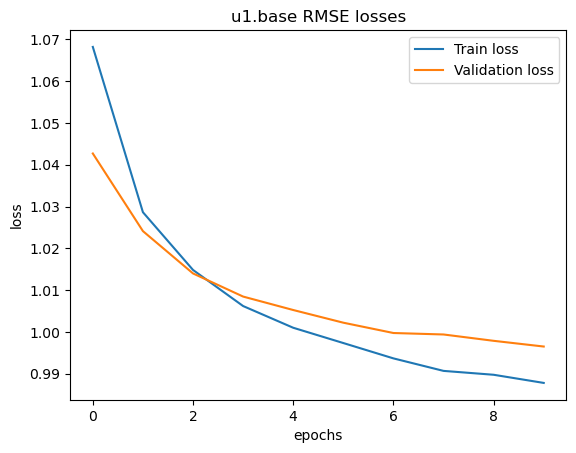

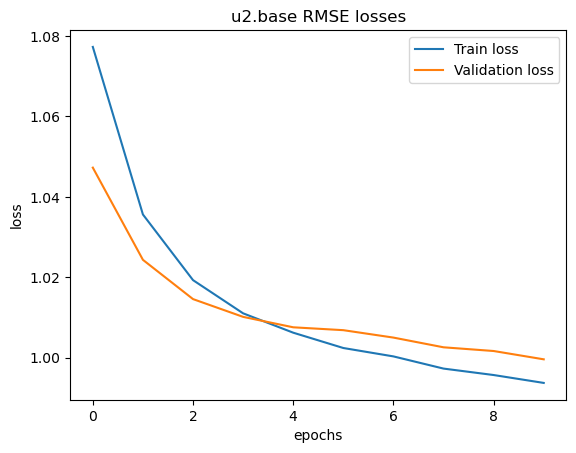

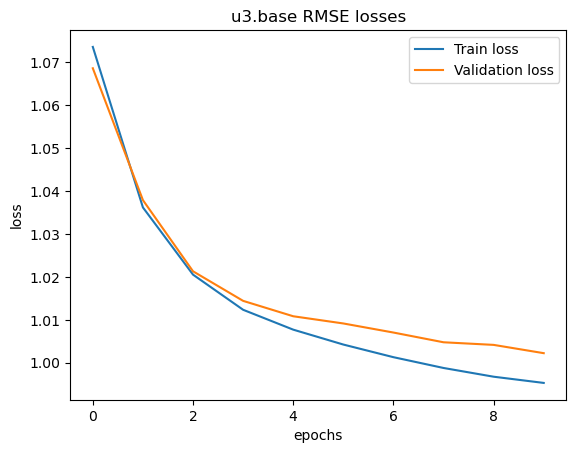

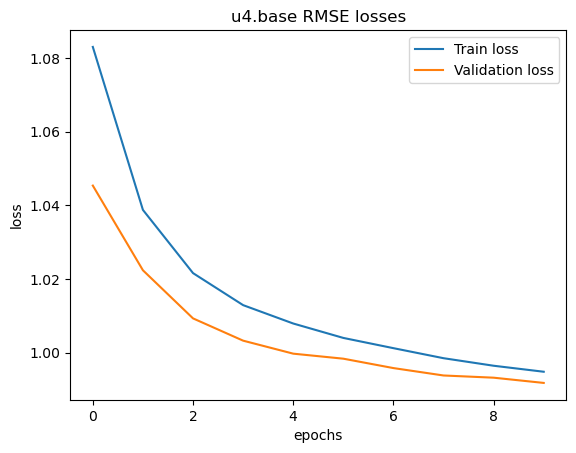

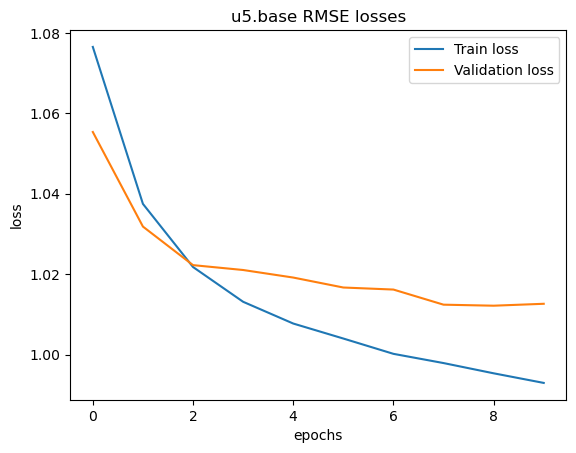

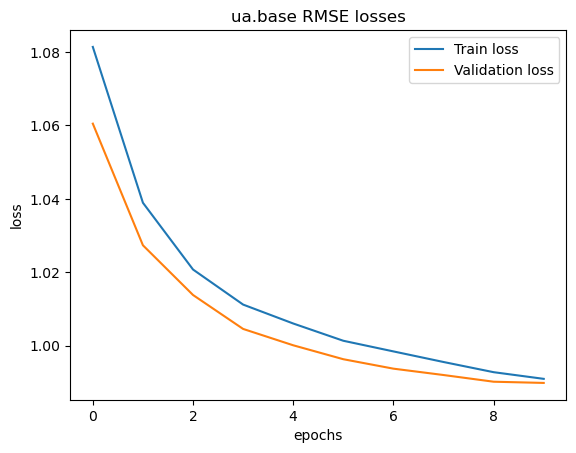

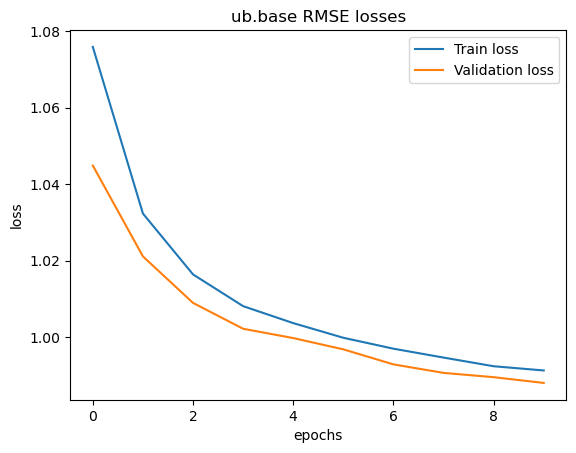

In [20]:
import matplotlib.pyplot as plt

for part in data_parts:
    filepath = os.path.join(LOGS_DIR_PATH, f"train_{part}.txt")
    with open(filepath, "r") as loss_file:
        data = loss_file.read().split("\n")
        train_loss, val_loss = eval(data[0]), eval(data[1])

    # Plot loss/epoch plots
    plt.plot([i for i in range(len(train_loss))], train_loss, label="Train loss")
    plt.plot([i for i in range(len(val_loss))], val_loss, label="Validation loss")
    # Set labels and titles
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(f"u{part}.base RMSE losses")
    plt.legend()
    plt.savefig(os.path.join(BENCHMARK_DIR_PATH, f"plots/u{part}.base_loss.png"))
    plt.show()

## Evaluation

In [9]:
model = RecSystem(user_dim=24, movie_dim=19, hidden_dim=128).to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH.format("1")))
model.eval()

RecSystem(
  (gnn): GNNModel(
    (conv1): HeteroConv(num_relations=2)
    (conv2): HeteroConv(num_relations=2)
  )
  (cos_sim): CosineSimilarity()
)

In [10]:
with torch.no_grad():
    # Load train data
    data = HeteroData(_mapping=torch.load(f"../data/prepared/data1_test.pt"))
    user_number = data["user"].x.shape[0]
    movie_number = data["movie"].x.shape[0]

    full_edges = torch.zeros((2, user_number * movie_number))
    for user in range(user_number):
        for movie in range(movie_number):
            full_edges[0][(user + 1) * (movie + 1) - 1] = user
            full_edges[1][(user + 1) * (movie + 1) - 1] = movie
    # Predict for each user rating for each movie
    embeds = model(data, get_embeddings=True)
    full_predictions = model.predict_ratings(embeds["user"], embeds["movie"], full_edges.long())
    torch.save(full_predictions, "../benchmark/full_predictions.pt")